In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
from PIL import Image
from matplotlib import pyplot as plt
import xml.etree.ElementTree as ET
import torch
import torchvision
import os
#from google.colab import drive
#drive.mount('/content/drive')

# Any results you write to the current directory are saved as output.

In [2]:
os.chdir('/Users/USER/OneDrive/桌面/PELVIS_DATASET') #切換該目錄
os.listdir() #確認目錄內容

['1022_resneSt.pth',
 '1022_ResNet18.pth',
 '1022_ResNet34.pth',
 'googlenet.pth',
 'model_7_29.pth',
 'model_7_31.pth',
 'model_8_3.pth',
 'resneSt.pth',
 'resnet18_8_5.pth',
 'resnet18_best.pth',
 'train_image',
 'train_label',
 'val_image',
 'val_label']

In [3]:
from PIL import Image
import numpy as np
import os

def data_statistic(image_dir, xml_dir):
    images = []
    labels = []

    for img_file in os.listdir(image_dir):
        if img_file.endswith('.png'):
            img_path = os.path.join(image_dir, img_file)
            label_file = img_file.replace('.png', '.xml')
            label_path = os.path.join(xml_dir, label_file)

            image = Image.open(img_path)
            image = image.resize((256, 256))
            images.append(np.array(image))

            labels.append(label_path)

    return images, labels

# 载入数据集
image_dir = '/Users/USER/OneDrive/桌面/PELVIS_DATASET/train_image'
xml_dir = '/Users/USER/OneDrive/桌面/PELVIS_DATASET/train_label'

images, labels = data_statistic(image_dir, xml_dir)


In [4]:
images = os.listdir(image_dir)
print("Number of Images: ", len(images))

Number of Images:  312


In [5]:
images_to_display = random.choices(images, k=6)

fig = plt.figure(figsize=(225, 225))
for ii, img in enumerate(images_to_display):
    ax = fig.add_subplot(3, 3, ii + 1, xticks=[], yticks=[])

    img = Image.open(os.path.join(image_dir, img))
    plt.imshow(img)

In [6]:
from torch.utils.data import Dataset
from PIL import Image
import xml.etree.ElementTree as ET
from torchvision.transforms import ToTensor
import os
import torch

class CustomDataset(Dataset):
    def __init__(self, image_dir, xml_dir, transform=None):
        self.image_dir = image_dir
        self.xml_dir = xml_dir
        self.transform = transform
        self.loaded_images = []
        self.loaded_bboxes = []
        self.loaded_labels = []
        self.load_data()

    def __len__(self):
        return len(self.loaded_images)

    def __getitem__(self, idx):
        img = self.loaded_images[idx]
        bbox = self.loaded_bboxes[idx]
        label = self.loaded_labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label)

    def load_data(self):
        for img_file in os.listdir(self.image_dir):
            if img_file.endswith('.png'):
                img_path = os.path.join(self.image_dir, img_file)
                label_file = img_file.replace('.png', '.xml')
                label_path = os.path.join(self.xml_dir, label_file)

                loaded_images, loaded_bboxes, loaded_labels = self.ImageLoader(img_path, label_path)
                self.loaded_images.extend(loaded_images)
                self.loaded_bboxes.extend(loaded_bboxes)
                self.loaded_labels.extend(loaded_labels)

    def ImageLoader(self, img_path, label_path):
        bbox_list = []

        label_list = []
        loaded_images = []
        loaded_bboxes = []
        loaded_labels = []

        tree = ET.parse(label_path)
        root = tree.getroot()

        objects = root.findall('object')
        for obj in objects:
            label = obj.find('name').text
            bmd, diagnosis = label.strip('()').split(',')
            bmd_value = float(bmd.strip())
            diagnosis = diagnosis.strip()
            # Map the diagnosis to class index
            if diagnosis == 'osteoporosis':
                label_idx = 1
            elif diagnosis == 'osteopenia':
                label_idx = 0

            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            bbox = (xmin, ymin, xmax, ymax)
            bbox_list.append(bbox)
            label_list.append(label)


        img = Image.open(img_path)
        for bbox, label in zip(bbox_list, label_list):
            cropped_img = img #img.crop(bbox)
            cropped_img = cropped_img.resize((224, 224), Image.ANTIALIAS)
            # 将图像转换为RGB模式
            cropped_img = cropped_img.convert('RGB')
            loaded_images.append(cropped_img)
            loaded_bboxes.append(bbox)
            loaded_labels.append(label_idx)

        return loaded_images, loaded_bboxes, loaded_labels



# 创建数据集和转换
train_dataset = CustomDataset(
    image_dir='/Users/USER/OneDrive/桌面/PELVIS_DATASET/train_image',
    xml_dir='/Users/USER/OneDrive/桌面/PELVIS_DATASET/train_label',
    transform=ToTensor()
)

dataset_length = len(train_dataset)
print(dataset_length)

C:\Users\User\AppData\Local\Temp\ipykernel_19720\1543842159.py:79: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  cropped_img = cropped_img.resize((224, 224), Image.ANTIALIAS)


312


In [7]:
# 创建数据集和转换
val_dataset = CustomDataset(
    image_dir='/Users/USER/OneDrive/桌面/PELVIS_DATASET/val_image',
    xml_dir='/Users/USER/OneDrive/桌面/PELVIS_DATASET/val_label',
    transform=ToTensor()
)

C:\Users\User\AppData\Local\Temp\ipykernel_19720\1543842159.py:79: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  cropped_img = cropped_img.resize((224, 224), Image.ANTIALIAS)


In [8]:
dataset_length = len(val_dataset)
print(dataset_length)

84


In [9]:
from torchvision import transforms

# 定义随机旋转角度范围（以度为单位）
rotation_range = (-20, 20)
brightness_range = (0.95, 1.05)  # 亮度范围为原始亮度的95%到105%

# 定義每個轉換的機率為15%
rotation_prob = 0.2
brightness_prob = 0.3

# 创建数据增强的变换
data_rotation = transforms.Compose([
    transforms.RandomRotation(rotation_range),
    #transforms.RandomApply([transforms.RandomRotation(rotation_range)], p=rotation_prob),
    transforms.RandomApply([transforms.ColorJitter(brightness=brightness_range)], p=brightness_prob),
    transforms.Resize((224, 224)),
    ToTensor()
])

# 对数据集应用数据增强变换
rotation_dataset = CustomDataset(
    image_dir='/Users/USER/OneDrive/桌面/PELVIS_DATASET/train_image',
    xml_dir='/Users/USER/OneDrive/桌面/PELVIS_DATASET/train_label',
    transform=data_rotation
)

C:\Users\User\AppData\Local\Temp\ipykernel_19720\1543842159.py:79: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  cropped_img = cropped_img.resize((224, 224), Image.ANTIALIAS)


In [10]:
dataset_length = len(rotation_dataset)
print(dataset_length)

312


In [11]:
from torchvision import transforms


# 創建數據增強的變換
data_flip = transforms.Compose([
    transforms.functional.hflip,
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# 对数据集应用数据增强变换
right_hip_dataset = CustomDataset(
    image_dir='/Users/USER/OneDrive/桌面/right_hip/image',
    xml_dir='/Users/USER/OneDrive/桌面/right_hip/label',
    transform=data_flip 
)

C:\Users\User\AppData\Local\Temp\ipykernel_19720\1543842159.py:79: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  cropped_img = cropped_img.resize((224, 224), Image.ANTIALIAS)


In [12]:
dataset_length = len(right_hip_dataset)
print(dataset_length)

297


In [13]:
from torchvision import transforms

# 定义随机旋转角度范围（以度为单位）
rotation_range = (-20, 20)
brightness_range = (0.95, 1.05)  # 亮度范围为原始亮度的95%到105%

# 定義每個轉換的機率為15%
rotation_prob = 0.2
brightness_prob = 0.3
# 創建數據增強的變換
data_flip = transforms.Compose([
    transforms.functional.hflip,
    transforms.RandomRotation(rotation_range),
    #transforms.RandomApply([transforms.RandomRotation(rotation_range)], p=rotation_prob),
    transforms.RandomApply([transforms.ColorJitter(brightness=brightness_range)], p=brightness_prob),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# 对数据集应用数据增强变换
right_hip_transform = CustomDataset(
    image_dir='/Users/USER/OneDrive/桌面/right_hip/image',
    xml_dir='/Users/USER/OneDrive/桌面/right_hip/label',
    transform=data_flip 
)

C:\Users\User\AppData\Local\Temp\ipykernel_19720\1543842159.py:79: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  cropped_img = cropped_img.resize((224, 224), Image.ANTIALIAS)


In [14]:
dataset_length = len(right_hip_transform)
print(dataset_length)

297


In [15]:
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset

combined_dataset = ConcatDataset([train_dataset,rotation_dataset,right_hip_dataset,right_hip_transform])

In [16]:
dataset_length = len(combined_dataset)
print(dataset_length)

1218


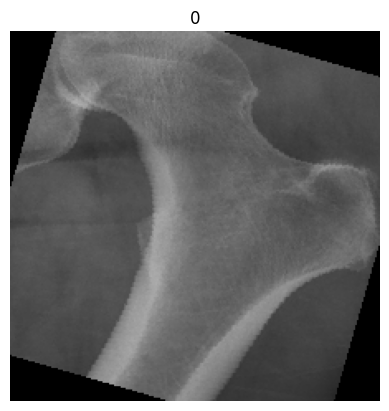

In [17]:
import matplotlib.pyplot as plt

data_point =combined_dataset[1100]
tensor, _ = data_point
label_tensor = torch.tensor(0)  # 將標籤值設置為 tensor(0)

label = str(label_tensor.item())  # 將標籤 tensor 轉換為字串

image = tensor.permute(1, 2, 0)  # 將通道維度移到最後

plt.imshow(image)
plt.title(label)  # 設置標題為標籤值的字串形式
plt.axis('off')
plt.show()


In [18]:
#import matplotlib.pyplot as plt

#_, axes = plt.subplots(figsize=(224, 224), ncols=3, nrows=3)

#for i, ax in enumerate(axes.flatten()):
#    tensor, label = rotation_dataset[i]
#    image = tensor.permute(1, 2, 0)  # 將通道維度移到最後
#    ax.imshow(image)
#    ax.set_title(label)  # 設置標題為標籤值
#    ax.axis('off')

#plt.show()




In [19]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision
from torchvision import transforms
from collections import OrderedDict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


In [20]:
num_of_osteoporosis = 0
num_of_osteopenia = 0

for _,  label in combined_dataset:
    if label.item() == 1:  # 將 Tensor 轉換為整數值進行比較
        num_of_osteoporosis += 1
    elif label.item() == 0:
        num_of_osteopenia += 1

print(f"Total number of samples in osteoporosis class: {num_of_osteoporosis}")
print(f"Total number of samples in osteopenia class: {num_of_osteopenia}")

Total number of samples in osteoporosis class: 530
Total number of samples in osteopenia class: 688


In [21]:
import random

# 計算兩個類別的數量
count_osteoporosis = num_of_osteoporosis
count_osteopenia = num_of_osteopenia

# 決定從 "osteopenia" 類別中隨機選取多少樣本
num_samples_to_keep = count_osteoporosis

# 進行隨機欠採樣，將 "osteopenia" 類別的樣本數量減少到與 "osteoporosis" 相同
under_sampling_dataset = []
num_samples_kept = 0

for sample, label in combined_dataset:
    if label.item() == 0:  # "osteopenia" 類別
        if num_samples_kept < num_samples_to_keep:
            under_sampling_dataset.append((sample,label))
            num_samples_kept += 1
        else:
            # 跳過額外的 "osteopenia" 樣本
            continue
    else:  # "osteoporosis" 類別
        under_sampling_dataset.append((sample, label))

In [22]:
count_osteoporosis = 0
count_osteopenia = 0

for _,  label in under_sampling_dataset:
    if label.item() == 1:  # 將 Tensor 轉換為整數值進行比較
        count_osteoporosis += 1
    elif label.item() == 0:
        count_osteopenia += 1
print(f"Total number of samples in osteoporosis class: {count_osteoporosis}")
print(f"Total number of samples in osteopenia class: {count_osteopenia}")

Total number of samples in osteoporosis class: 530
Total number of samples in osteopenia class: 530


In [23]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU可用")
else:
    device = torch.device("cpu")
    print("GPU不可用")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


GPU可用


#  Resnet 18

Fold 1/5
----------


C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50
----------
Train Loss: 0.6390 Acc: 0.6386
Val Loss: 0.7642 Acc: 0.5943
Epoch 2/50
----------
Train Loss: 0.5400 Acc: 0.7382
Val Loss: 0.5187 Acc: 0.7459
Epoch 3/50
----------
Train Loss: 0.4301 Acc: 0.8090
Val Loss: 0.3610 Acc: 0.8402
Epoch 4/50
----------
Train Loss: 0.3435 Acc: 0.8460
Val Loss: 0.4410 Acc: 0.8115
Epoch 5/50
----------
Train Loss: 0.3716 Acc: 0.8409
Val Loss: 0.3599 Acc: 0.8484
Epoch 6/50
----------
Train Loss: 0.2943 Acc: 0.8799
Val Loss: 0.3767 Acc: 0.8525
Epoch 7/50
----------
Train Loss: 0.2512 Acc: 0.9066
Val Loss: 0.3345 Acc: 0.8648
Epoch 8/50
----------
Train Loss: 0.1769 Acc: 0.9220
Val Loss: 0.2745 Acc: 0.8730
Epoch 9/50
----------
Train Loss: 0.2729 Acc: 0.8963
Val Loss: 0.4726 Acc: 0.7746
Epoch 10/50
----------
Train Loss: 0.2304 Acc: 0.9086
Val Loss: 0.4049 Acc: 0.8156
Epoch 11/50
----------
Train Loss: 0.2384 Acc: 0.9035
Val Loss: 0.1674 Acc: 0.9262
Epoch 12/50
----------
Train Loss: 0.1883 Acc: 0.9333
Val Loss: 0.2384 Acc: 0.9016
Epoch 13/50
-

Train Loss: 0.0850 Acc: 0.9733
Val Loss: 0.0910 Acc: 0.9713
Fold 3/5
----------
Epoch 1/50
----------
Train Loss: 0.6492 Acc: 0.6355
Val Loss: 0.8618 Acc: 0.5164
Epoch 2/50
----------
Train Loss: 0.6242 Acc: 0.6776
Val Loss: 0.4836 Acc: 0.7582
Epoch 3/50
----------
Train Loss: 0.4397 Acc: 0.7906
Val Loss: 0.5605 Acc: 0.7664
Epoch 4/50
----------
Train Loss: 0.4206 Acc: 0.8121
Val Loss: 0.5495 Acc: 0.7049
Epoch 5/50
----------
Train Loss: 0.3458 Acc: 0.8501
Val Loss: 0.4823 Acc: 0.7828
Epoch 6/50
----------
Train Loss: 0.3353 Acc: 0.8583
Val Loss: 0.2529 Acc: 0.9057
Epoch 7/50
----------
Train Loss: 0.2772 Acc: 0.8871
Val Loss: 0.3071 Acc: 0.8689
Epoch 8/50
----------
Train Loss: 0.2438 Acc: 0.8912
Val Loss: 0.6031 Acc: 0.7213
Epoch 9/50
----------
Train Loss: 0.2624 Acc: 0.8871
Val Loss: 0.2134 Acc: 0.9098
Epoch 10/50
----------
Train Loss: 0.2408 Acc: 0.9055
Val Loss: 0.2392 Acc: 0.9016
Epoch 11/50
----------
Train Loss: 0.2020 Acc: 0.9261
Val Loss: 0.2629 Acc: 0.9262
Epoch 12/50
----

Train Loss: 0.0579 Acc: 0.9867
Val Loss: 0.0788 Acc: 0.9712
Epoch 50/50
----------
Train Loss: 0.0973 Acc: 0.9723
Val Loss: 0.1029 Acc: 0.9630
Fold 5/5
----------
Epoch 1/50
----------
Train Loss: 0.6798 Acc: 0.6236
Val Loss: 0.5209 Acc: 0.7325
Epoch 2/50
----------
Train Loss: 0.5415 Acc: 0.7405
Val Loss: 0.5134 Acc: 0.7490
Epoch 3/50
----------
Train Loss: 0.4516 Acc: 0.7949
Val Loss: 0.4066 Acc: 0.7984
Epoch 4/50
----------
Train Loss: 0.3820 Acc: 0.8349
Val Loss: 0.3389 Acc: 0.8313
Epoch 5/50
----------
Train Loss: 0.3558 Acc: 0.8564
Val Loss: 0.4421 Acc: 0.8025
Epoch 6/50
----------
Train Loss: 0.3583 Acc: 0.8482
Val Loss: 0.6402 Acc: 0.7119
Epoch 7/50
----------
Train Loss: 0.2975 Acc: 0.8718
Val Loss: 0.5738 Acc: 0.7613
Epoch 8/50
----------
Train Loss: 0.3052 Acc: 0.8749
Val Loss: 0.3639 Acc: 0.8313
Epoch 9/50
----------
Train Loss: 0.2070 Acc: 0.9200
Val Loss: 0.3059 Acc: 0.8724
Epoch 10/50
----------
Train Loss: 0.2481 Acc: 0.9005
Val Loss: 0.3004 Acc: 0.8889
Epoch 11/50
----

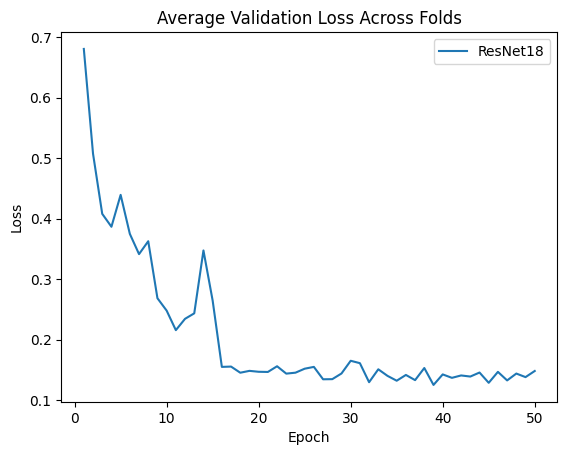

In [24]:
import torch
import numpy as np
from sklearn.model_selection import KFold
import time
start_time = time.time() 

best_val_loss = float('inf')
best_model = None

batch_size = 5
k = 5  # 折叠数
num_epochs = 50

kfold = KFold(n_splits=k, shuffle=True)

# 初始化一个数组来保存每个折叠的验证损失
r18_val_losses_list = []

# 通过循环，每个折叠都创建一个新的模型并进行训练
for fold, (train_indices, val_indices) in enumerate(kfold.split(combined_dataset)):
    print(f"Fold {fold+1}/{k}")
    print("-" * 10)
     
    # 根据索引创建训练集和验证集的子集
    train_subset = torch.utils.data.Subset(combined_dataset, train_indices)
    val_subset = torch.utils.data.Subset(combined_dataset, val_indices)

    # 创建训练集和验证集的数据加载器
    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    
    # 載入預訓練模型
    model = models.resnet18(pretrained=True)
    model = model.to(device)
    
    # 将模型的最后一层替换为适合你的任务的新的全连接层
    num_classes = 1  # 因為使用 BCEWithLogitsLoss，只需一個輸出節點
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    # 定义损失函数
    criterion = nn.BCEWithLogitsLoss()
    
    # 定义优化器
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)
    
    # 设置学习率调度器（可选）
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1) 

    # 初始化训练和验证损失列表
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        # 訓練階段
        model.train()
        train_loss = 0.0
        train_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = (labels.unsqueeze(1)).to(device) 
            model = model.to(device)
            optimizer.zero_grad()

            # 前向傳播
            outputs = model(inputs)
            
            #用來算ACC
            pred = torch.sigmoid(outputs).round().long()
            
            loss = criterion(outputs, labels.float())
            # 反向傳播和參數更新
            loss.backward()
            optimizer.step()
        
        
            train_loss += loss.item() * inputs.size(0)
            train_corrects += torch.sum(torch.eq(pred, labels))

            
        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_corrects / len(train_loader.dataset)

        print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")
        train_losses.append(train_loss)

        # 驗證階段
        model.eval()
        val_loss = 0.0
        val_corrects = 0
    
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = (labels.unsqueeze(1)).to(device) 
                
                # 前向傳播
                outputs = model(inputs)
                
                #用來算ACC
                pred = torch.sigmoid(outputs).round().long()
                
                loss = criterion(outputs, labels.float())

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(torch.eq(pred, labels))

        val_loss = val_loss / len(test_loader.dataset)
        val_acc = val_corrects / len(test_loader.dataset)

        print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
        val_losses.append(val_loss)

        # 學習率調度器更新
        scheduler.step()
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        Fold = fold+1
        R18_best_model = model.state_dict()
    
    # 繪製每个 epoch 的训练和验证损失折线图
    #plt.plot(range(1, epoch + 2), train_losses, label=f'Fold {fold+1} Training Loss')
    #plt.plot(range(1, epoch + 2), val_losses, label=f'Fold {fold+1} Validation Loss')
    #plt.xlabel('Epoch')
    #plt.ylabel('Loss')
    #plt.title('Training and Validation Loss')
    #plt.legend()
    #plt.show()
        
    # 将每个折叠的验证损失列表保存到总列表中
    r18_val_losses_list.append(val_losses)

# 记录结束时间
end_time = time.time()
# 计算时间差
execution_time = end_time - start_time
# 输出执行时间
print(f"Execution time: {execution_time} seconds")
print(f"Fold {Fold} is the best")

# 将验证损失列表转换为numpy数组
val_losses_array = np.array(r18_val_losses_list)

# 计算所有折叠的验证损失平均值
r18_mean_val_losses = np.mean(val_losses_array, axis=0)

# 绘制每个折叠的验证损失平均折线图
plt.plot(range(1, num_epochs + 1), r18_mean_val_losses, label='ResNet18')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Validation Loss Across Folds')
plt.legend()
plt.show()


In [25]:
# 現在你的模型已經準備好進行預測了
# 如果是進行預測，你可以將你的輸入資料（例如：val_loader）餵入模型
# 然後獲得模型的預測結果（例如：y_pred）和真實標籤（例如：y_true）：
y_true = []
y_pred = []

with torch.no_grad():
    model.eval()
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 前向傳播
        outputs = model(inputs)
        preds = torch.sigmoid(outputs).round().long()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# 計算混淆矩陣
confusion_mat = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(confusion_mat)

# 生成分類報告
report = classification_report(y_true, y_pred)

print("Classification Report:")
print(report)


Confusion Matrix:
[[142   7]
 [  5  89]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       149
           1       0.93      0.95      0.94        94

    accuracy                           0.95       243
   macro avg       0.95      0.95      0.95       243
weighted avg       0.95      0.95      0.95       243



#  ResNet 34

Fold 1/5
----------


C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50
----------
Train Loss: 0.6517 Acc: 0.6448
Val Loss: 0.5566 Acc: 0.7090
Epoch 2/50
----------
Train Loss: 0.5170 Acc: 0.7567
Val Loss: 0.4564 Acc: 0.7992
Epoch 3/50
----------
Train Loss: 0.4577 Acc: 0.7875
Val Loss: 0.3553 Acc: 0.8689
Epoch 4/50
----------
Train Loss: 0.3463 Acc: 0.8676
Val Loss: 0.5830 Acc: 0.7254
Epoch 5/50
----------
Train Loss: 0.3437 Acc: 0.8542
Val Loss: 0.3657 Acc: 0.8320
Epoch 6/50
----------
Train Loss: 0.2785 Acc: 0.8963
Val Loss: 0.2799 Acc: 0.8852
Epoch 7/50
----------
Train Loss: 0.2682 Acc: 0.8912
Val Loss: 0.2853 Acc: 0.8648
Epoch 8/50
----------
Train Loss: 0.2316 Acc: 0.9097
Val Loss: 0.1999 Acc: 0.9221
Epoch 9/50
----------
Train Loss: 0.2214 Acc: 0.9240
Val Loss: 0.2643 Acc: 0.8811
Epoch 10/50
----------
Train Loss: 0.1922 Acc: 0.9302
Val Loss: 0.2103 Acc: 0.9508
Epoch 11/50
----------
Train Loss: 0.1594 Acc: 0.9374
Val Loss: 0.2340 Acc: 0.9016
Epoch 12/50
----------
Train Loss: 0.1903 Acc: 0.9333
Val Loss: 0.2206 Acc: 0.9139
Epoch 13/50
-

Train Loss: 0.0329 Acc: 0.9918
Val Loss: 0.1858 Acc: 0.9303
Fold 3/5
----------
Epoch 1/50
----------
Train Loss: 0.6800 Acc: 0.6253
Val Loss: 0.7175 Acc: 0.6762
Epoch 2/50
----------
Train Loss: 0.5404 Acc: 0.7464
Val Loss: 0.5489 Acc: 0.7336
Epoch 3/50
----------
Train Loss: 0.4354 Acc: 0.8101
Val Loss: 0.8774 Acc: 0.6189
Epoch 4/50
----------
Train Loss: 0.4004 Acc: 0.8080
Val Loss: 0.3807 Acc: 0.8279
Epoch 5/50
----------
Train Loss: 0.3636 Acc: 0.8460
Val Loss: 1.0452 Acc: 0.5697
Epoch 6/50
----------
Train Loss: 0.2990 Acc: 0.8871
Val Loss: 0.7328 Acc: 0.6762
Epoch 7/50
----------
Train Loss: 0.2380 Acc: 0.9045
Val Loss: 0.2981 Acc: 0.8893
Epoch 8/50
----------
Train Loss: 0.2499 Acc: 0.9004
Val Loss: 0.2224 Acc: 0.9057
Epoch 9/50
----------
Train Loss: 0.2711 Acc: 0.8891
Val Loss: 0.2286 Acc: 0.8893
Epoch 10/50
----------
Train Loss: 0.2240 Acc: 0.9107
Val Loss: 0.2725 Acc: 0.8893
Epoch 11/50
----------
Train Loss: 0.1936 Acc: 0.9271
Val Loss: 0.3570 Acc: 0.8648
Epoch 12/50
----

Train Loss: 0.0514 Acc: 0.9856
Val Loss: 0.1017 Acc: 0.9588
Epoch 50/50
----------
Train Loss: 0.0277 Acc: 0.9938
Val Loss: 0.0705 Acc: 0.9753
Fold 5/5
----------
Epoch 1/50
----------
Train Loss: 0.6238 Acc: 0.6738
Val Loss: 0.8918 Acc: 0.5926
Epoch 2/50
----------
Train Loss: 0.5264 Acc: 0.7631
Val Loss: 0.5332 Acc: 0.7613
Epoch 3/50
----------
Train Loss: 0.4228 Acc: 0.8185
Val Loss: 0.5355 Acc: 0.7613
Epoch 4/50
----------
Train Loss: 0.3493 Acc: 0.8451
Val Loss: 0.3412 Acc: 0.8519
Epoch 5/50
----------
Train Loss: 0.3233 Acc: 0.8585
Val Loss: 0.6640 Acc: 0.6996
Epoch 6/50
----------
Train Loss: 0.2623 Acc: 0.8903
Val Loss: 0.3436 Acc: 0.8560
Epoch 7/50
----------
Train Loss: 0.2312 Acc: 0.9097
Val Loss: 0.2953 Acc: 0.8724
Epoch 8/50
----------
Train Loss: 0.2206 Acc: 0.9169
Val Loss: 0.3270 Acc: 0.8601
Epoch 9/50
----------
Train Loss: 0.2091 Acc: 0.9313
Val Loss: 0.4300 Acc: 0.8025
Epoch 10/50
----------
Train Loss: 0.1689 Acc: 0.9374
Val Loss: 0.4041 Acc: 0.8230
Epoch 11/50
----

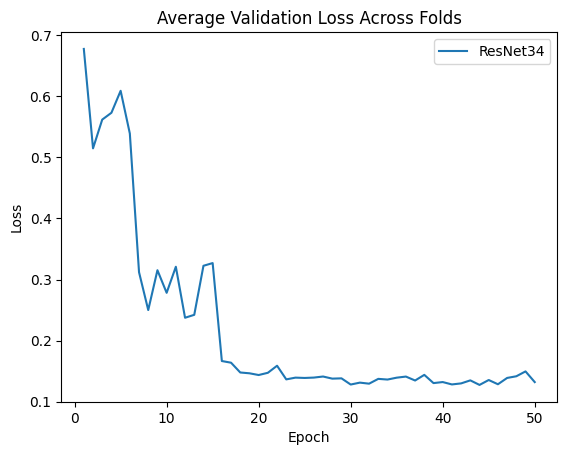

In [26]:
import torch
import numpy as np
from sklearn.model_selection import KFold
import time
start_time = time.time() 

R34_best_val_loss = float('inf')
R34_best_model = None

batch_size = 5
k = 5  # 折叠数
num_epochs = 50

kfold = KFold(n_splits=k, shuffle=True)

# 初始化一个数组来保存每个折叠的验证损失
r34_val_losses_list = []

# 通过循环，每个折叠都创建一个新的模型并进行训练
for fold, (train_indices, val_indices) in enumerate(kfold.split(combined_dataset)):
    print(f"Fold {fold+1}/{k}")
    print("-" * 10)
     
    # 根据索引创建训练集和验证集的子集
    train_subset = torch.utils.data.Subset(combined_dataset, train_indices)
    val_subset = torch.utils.data.Subset(combined_dataset, val_indices)

    # 创建训练集和验证集的数据加载器
    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    
    # 載入預訓練模型
    model = models.resnet34(pretrained=True)
    model = model.to(device)
    
    # 将模型的最后一层替换为适合你的任务的新的全连接层
    num_classes = 1  # 因為使用 BCEWithLogitsLoss，只需一個輸出節點
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    # 定义损失函数
    criterion = nn.BCEWithLogitsLoss()
    
    # 定义优化器
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)
    
    # 设置学习率调度器（可选）
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1) 

    # 初始化训练和验证损失列表
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        # 訓練階段
        model.train()
        train_loss = 0.0
        train_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = (labels.unsqueeze(1)).to(device) 
            model = model.to(device)
            optimizer.zero_grad()

            # 前向傳播
            outputs = model(inputs)
            
            #用來算ACC
            pred = torch.sigmoid(outputs).round().long()
            
            loss = criterion(outputs, labels.float())
            # 反向傳播和參數更新
            loss.backward()
            optimizer.step()
        
        
            train_loss += loss.item() * inputs.size(0)
            train_corrects += torch.sum(torch.eq(pred, labels))

            
        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_corrects / len(train_loader.dataset)

        print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")
        train_losses.append(train_loss)

        # 驗證階段
        model.eval()
        val_loss = 0.0
        val_corrects = 0
    
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = (labels.unsqueeze(1)).to(device) 
                
                # 前向傳播
                outputs = model(inputs)
                
                #用來算ACC
                pred = torch.sigmoid(outputs).round().long()
                
                loss = criterion(outputs, labels.float())

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(torch.eq(pred, labels))

        val_loss = val_loss / len(test_loader.dataset)
        val_acc = val_corrects / len(test_loader.dataset)

        print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
        val_losses.append(val_loss)

        # 學習率調度器更新
        scheduler.step()
    
    if val_loss < R34_best_val_loss:
        R34_best_val_loss = val_loss
        Fold = fold+1
        R34_best_model = model.state_dict()
    
    # 繪製每个 epoch 的训练和验证损失折线图
    #plt.plot(range(1, epoch + 2), train_losses, label=f'Fold {fold+1} Training Loss')
    #plt.plot(range(1, epoch + 2), val_losses, label=f'Fold {fold+1} Validation Loss')
    #plt.xlabel('Epoch')
    #plt.ylabel('Loss')
    #plt.title('Training and Validation Loss')
    #plt.legend()
    #plt.show()
        
    # 将每个折叠的验证损失列表保存到总列表中
    r34_val_losses_list.append(val_losses)

# 记录结束时间
end_time = time.time()
# 计算时间差
execution_time = end_time - start_time
# 输出执行时间
print(f"Execution time: {execution_time} seconds")
print(f"Fold {Fold} is the best")

# 将验证损失列表转换为numpy数组
val_losses_array = np.array(r34_val_losses_list)

# 计算所有折叠的验证损失平均值
r34_mean_val_losses = np.mean(val_losses_array, axis=0)

# 绘制每个折叠的验证损失平均折线图
plt.plot(range(1, num_epochs + 1), r34_mean_val_losses, label='ResNet34')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Validation Loss Across Folds')
plt.legend()
plt.show()


In [27]:
# 現在你的模型已經準備好進行預測了
# 如果是進行預測，你可以將你的輸入資料（例如：val_loader）餵入模型
# 然後獲得模型的預測結果（例如：y_pred）和真實標籤（例如：y_true）：
y_true = []
y_pred = []

with torch.no_grad():
    model.eval()
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 前向傳播
        outputs = model(inputs)
        preds = torch.sigmoid(outputs).round().long()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# 計算混淆矩陣
confusion_mat = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(confusion_mat)

# 生成分類報告
report = classification_report(y_true, y_pred)

print("Classification Report:")
print(report)

Confusion Matrix:
[[127   5]
 [  9 102]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       132
           1       0.95      0.92      0.94       111

    accuracy                           0.94       243
   macro avg       0.94      0.94      0.94       243
weighted avg       0.94      0.94      0.94       243



# GoogleNet

Fold 1/5
----------


C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50
----------
Train Loss: 0.6537 Acc: 0.6016
Val Loss: 0.5533 Acc: 0.7336
Epoch 2/50
----------
Train Loss: 0.5451 Acc: 0.7197
Val Loss: 0.4171 Acc: 0.8074
Epoch 3/50
----------
Train Loss: 0.4558 Acc: 0.7834
Val Loss: 0.3027 Acc: 0.8648
Epoch 4/50
----------
Train Loss: 0.3350 Acc: 0.8439
Val Loss: 0.2859 Acc: 0.8934
Epoch 5/50
----------
Train Loss: 0.3216 Acc: 0.8747
Val Loss: 0.2090 Acc: 0.9303
Epoch 6/50
----------
Train Loss: 0.2540 Acc: 0.8912
Val Loss: 0.2911 Acc: 0.8566
Epoch 7/50
----------
Train Loss: 0.2683 Acc: 0.8860
Val Loss: 0.2547 Acc: 0.8893
Epoch 8/50
----------
Train Loss: 0.2281 Acc: 0.9066
Val Loss: 0.2133 Acc: 0.9180
Epoch 9/50
----------
Train Loss: 0.2247 Acc: 0.9117
Val Loss: 0.2351 Acc: 0.9139
Epoch 10/50
----------
Train Loss: 0.2494 Acc: 0.8994
Val Loss: 0.3299 Acc: 0.8525
Epoch 11/50
----------
Train Loss: 0.2464 Acc: 0.9014
Val Loss: 0.1652 Acc: 0.9508
Epoch 12/50
----------
Train Loss: 0.1908 Acc: 0.9261
Val Loss: 0.3970 Acc: 0.8443
Epoch 13/50
-

Train Loss: 0.0826 Acc: 0.9754
Val Loss: 0.2359 Acc: 0.9344
Fold 3/5
----------
Epoch 1/50
----------
Train Loss: 0.6377 Acc: 0.6263
Val Loss: 0.5369 Acc: 0.7336
Epoch 2/50
----------
Train Loss: 0.5055 Acc: 0.7413
Val Loss: 0.5893 Acc: 0.7172
Epoch 3/50
----------
Train Loss: 0.3886 Acc: 0.8368
Val Loss: 0.6242 Acc: 0.7213
Epoch 4/50
----------
Train Loss: 0.3472 Acc: 0.8573
Val Loss: 0.3598 Acc: 0.8484
Epoch 5/50
----------
Train Loss: 0.3281 Acc: 0.8573
Val Loss: 0.3747 Acc: 0.8320
Epoch 6/50
----------
Train Loss: 0.2606 Acc: 0.8932
Val Loss: 0.3077 Acc: 0.8689
Epoch 7/50
----------
Train Loss: 0.2652 Acc: 0.8860
Val Loss: 0.2807 Acc: 0.8934
Epoch 8/50
----------
Train Loss: 0.2310 Acc: 0.9086
Val Loss: 0.2856 Acc: 0.9016
Epoch 9/50
----------
Train Loss: 0.2250 Acc: 0.9138
Val Loss: 0.3170 Acc: 0.8730
Epoch 10/50
----------
Train Loss: 0.1403 Acc: 0.9548
Val Loss: 0.2943 Acc: 0.9057
Epoch 11/50
----------
Train Loss: 0.1899 Acc: 0.9312
Val Loss: 0.3096 Acc: 0.8852
Epoch 12/50
----

Train Loss: 0.0676 Acc: 0.9846
Val Loss: 0.1376 Acc: 0.9547
Epoch 50/50
----------
Train Loss: 0.0842 Acc: 0.9754
Val Loss: 0.1314 Acc: 0.9547
Fold 5/5
----------
Epoch 1/50
----------
Train Loss: 0.6500 Acc: 0.6113
Val Loss: 0.5566 Acc: 0.7202
Epoch 2/50
----------
Train Loss: 0.5171 Acc: 0.7272
Val Loss: 0.4512 Acc: 0.7860
Epoch 3/50
----------
Train Loss: 0.4141 Acc: 0.8144
Val Loss: 0.4503 Acc: 0.7984
Epoch 4/50
----------
Train Loss: 0.3460 Acc: 0.8472
Val Loss: 0.3391 Acc: 0.8519
Epoch 5/50
----------
Train Loss: 0.3272 Acc: 0.8482
Val Loss: 0.3076 Acc: 0.8724
Epoch 6/50
----------
Train Loss: 0.2626 Acc: 0.8944
Val Loss: 0.3147 Acc: 0.8848
Epoch 7/50
----------
Train Loss: 0.3121 Acc: 0.8708
Val Loss: 0.2993 Acc: 0.8683
Epoch 8/50
----------
Train Loss: 0.2309 Acc: 0.9056
Val Loss: 0.2731 Acc: 0.8930
Epoch 9/50
----------
Train Loss: 0.2134 Acc: 0.9200
Val Loss: 0.1957 Acc: 0.9300
Epoch 10/50
----------
Train Loss: 0.1817 Acc: 0.9313
Val Loss: 0.2799 Acc: 0.8848
Epoch 11/50
----

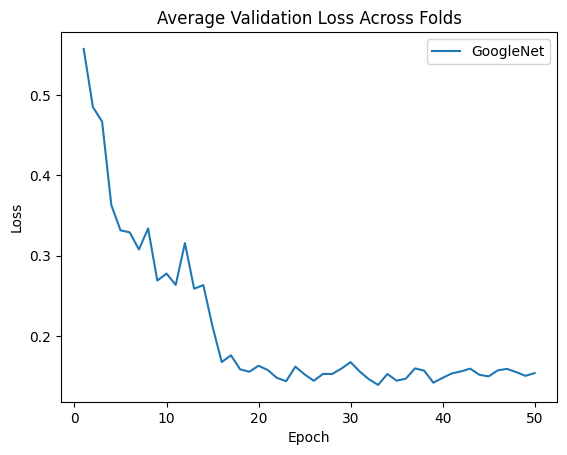

In [28]:
import torch
import numpy as np
from sklearn.model_selection import KFold
import time
start_time = time.time() 
from sklearn.metrics import mean_squared_error

googlenet_best_val_loss = float('inf') #mod
googlenet_best_model = None #mod

batch_size = 5
k = 5  # 折叠数
num_epochs = 50

kfold = KFold(n_splits=k, shuffle=True)

# 初始化一个数组来保存每个折叠的验证损失
googlenet_val_losses_list = [] #mod

# 通过循环，每个折叠都创建一个新的模型并进行训练
for fold, (train_indices, val_indices) in enumerate(kfold.split(combined_dataset)):
    print(f"Fold {fold+1}/{k}")
    print("-" * 10)
     
    # 根据索引创建训练集和验证集的子集
    train_subset = torch.utils.data.Subset(combined_dataset, train_indices)
    val_subset = torch.utils.data.Subset(combined_dataset, val_indices)

    # 创建训练集和验证集的数据加载器
    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    
    # 載入預訓練模型
    # get list of models
    model = models.googlenet(pretrained=True)
    model = model.to(device)
    
    # 将模型的最后一层替换为适合你的任务的新的全连接层
    num_classes = 1  # 因為使用 BCEWithLogitsLoss，只需一個輸出節點
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    # 定义损失函数
    criterion = nn.BCEWithLogitsLoss()
    
    # 定义优化器
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)
    
    # 设置学习率调度器（可选）
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1) 

    # 初始化训练和验证损失列表
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        # 訓練階段
        model.train()
        train_loss = 0.0
        train_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = (labels.unsqueeze(1)).to(device) 
            model = model.to(device)
            optimizer.zero_grad()

            # 前向傳播
            outputs = model(inputs)
            
            #用來算ACC
            pred = torch.sigmoid(outputs).round().long()
            
            loss = criterion(outputs, labels.float())
            # 反向傳播和參數更新
            loss.backward()
            optimizer.step()
        
        
            train_loss += loss.item() * inputs.size(0)
            train_corrects += torch.sum(torch.eq(pred, labels))

            
        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_corrects / len(train_loader.dataset)

        print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")
        train_losses.append(train_loss)

        # 驗證階段
        model.eval()
        val_loss = 0.0
        val_corrects = 0
    
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = (labels.unsqueeze(1)).to(device) 
                
                # 前向傳播
                outputs = model(inputs)
                
                #用來算ACC
                pred = torch.sigmoid(outputs).round().long()
                
                loss = criterion(outputs, labels.float())

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(torch.eq(pred, labels))

        val_loss = val_loss / len(test_loader.dataset)
        val_acc = val_corrects / len(test_loader.dataset)

        print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
        val_losses.append(val_loss)

        # 學習率調度器更新
        scheduler.step()
    
    if val_loss < googlenet_best_val_loss:
        googlenet_best_val_loss = val_loss #mod
        Fold = fold+1
        googlenet_best_model = model.state_dict() #mod
    
    # 繪製每个 epoch 的训练和验证损失折线图
    #plt.plot(range(1, epoch + 2), train_losses, label=f'Fold {fold+1} Training Loss')
    #plt.plot(range(1, epoch + 2), val_losses, label=f'Fold {fold+1} Validation Loss')
    #plt.xlabel('Epoch')
    #plt.ylabel('Loss')
    #plt.title('Training and Validation Loss')
    #plt.legend()
    #plt.show()
        
    # 将每个折叠的验证损失列表保存到总列表中
    googlenet_val_losses_list.append(val_losses) #mod

# 记录结束时间
end_time = time.time()
# 计算时间差
execution_time = end_time - start_time
# 输出执行时间
print(f"Execution time: {execution_time} seconds")
print(f"Fold {Fold} is the best")

# 将验证损失列表转换为numpy数组
val_losses_array = np.array(googlenet_val_losses_list) #mod

# 计算所有折叠的验证损失平均值
googlenet_mean_val_losses = np.mean(val_losses_array, axis=0) #mod

# 绘制每个折叠的验证损失平均折线图
plt.plot(range(1, num_epochs + 1), googlenet_mean_val_losses, label='GoogleNet') #mod
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Validation Loss Across Folds')
plt.legend()
plt.show()


In [32]:
# 現在你的模型已經準備好進行預測了
# 如果是進行預測，你可以將你的輸入資料（例如：val_loader）餵入模型
# 然後獲得模型的預測結果（例如：y_pred）和真實標籤（例如：y_true）：
y_true = []
y_pred = []

with torch.no_grad():
    model.eval()
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 前向傳播
        outputs = model(inputs)
        preds = torch.sigmoid(outputs).round().long()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# 計算混淆矩陣
confusion_mat = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(confusion_mat)

# 生成分類報告
report = classification_report(y_true, y_pred)

print("Classification Report:")
print(report)

Confusion Matrix:
[[119  10]
 [  3 111]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       129
           1       0.92      0.97      0.94       114

    accuracy                           0.95       243
   macro avg       0.95      0.95      0.95       243
weighted avg       0.95      0.95      0.95       243



# DenseNet

Fold 1/5
----------


Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50
----------
Train Loss: 0.6723 Acc: 0.6201
Val Loss: 0.5037 Acc: 0.7664
Epoch 2/50
----------
Train Loss: 0.5543 Acc: 0.7207
Val Loss: 0.5481 Acc: 0.7541
Epoch 3/50
----------
Train Loss: 0.3964 Acc: 0.8306
Val Loss: 0.5086 Acc: 0.7664
Epoch 4/50
----------
Train Loss: 0.4267 Acc: 0.8234
Val Loss: 0.5267 Acc: 0.7213
Epoch 5/50
----------
Train Loss: 0.3509 Acc: 0.8491
Val Loss: 0.9007 Acc: 0.6066
Epoch 6/50
----------
Train Loss: 0.3370 Acc: 0.8573
Val Loss: 0.3642 Acc: 0.7951
Epoch 7/50
----------
Train Loss: 0.2586 Acc: 0.9014
Val Loss: 0.2150 Acc: 0.9262
Epoch 8/50
----------
Train Loss: 0.2904 Acc: 0.8901
Val Loss: 0.5064 Acc: 0.7418
Epoch 9/50
----------
Train Loss: 0.2500 Acc: 0.9066
Val Loss: 0.2420 Acc: 0.9016
Epoch 10/50
----------
Train Loss: 0.2144 Acc: 0.9189
Val Loss: 0.4413 Acc: 0.8320
Epoch 11/50
----------
Train Loss: 0.2559 Acc: 0.9107
Val Loss: 0.2179 Acc: 0.9098
Epoch 12/50
----------
Train Loss: 0.2347 Acc: 0.9076
Val Loss: 0.2032 Acc: 0.9344
Epoch 13/50
-

Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.10.0


Epoch 1/50
----------
Train Loss: 0.6319 Acc: 0.6530
Val Loss: 0.5019 Acc: 0.7377
Epoch 2/50
----------
Train Loss: 0.5189 Acc: 0.7413
Val Loss: 0.4266 Acc: 0.8115
Epoch 3/50
----------
Train Loss: 0.4802 Acc: 0.7752
Val Loss: 0.4990 Acc: 0.7705
Epoch 4/50
----------
Train Loss: 0.3982 Acc: 0.8255
Val Loss: 0.2920 Acc: 0.8852
Epoch 5/50
----------
Train Loss: 0.3175 Acc: 0.8758
Val Loss: 0.3077 Acc: 0.8607
Epoch 6/50
----------
Train Loss: 0.3679 Acc: 0.8316
Val Loss: 0.6872 Acc: 0.7705
Epoch 7/50
----------
Train Loss: 0.3545 Acc: 0.8542
Val Loss: 0.2930 Acc: 0.8934
Epoch 8/50
----------
Train Loss: 0.2213 Acc: 0.9138
Val Loss: 0.2501 Acc: 0.9016
Epoch 9/50
----------
Train Loss: 0.2574 Acc: 0.9076
Val Loss: 0.1955 Acc: 0.9303
Epoch 10/50
----------
Train Loss: 0.2346 Acc: 0.9127
Val Loss: 0.2263 Acc: 0.9016
Epoch 11/50
----------
Train Loss: 0.1744 Acc: 0.9312
Val Loss: 0.2311 Acc: 0.9098
Epoch 12/50
----------
Train Loss: 0.2050 Acc: 0.9199
Val Loss: 0.3123 Acc: 0.8893
Epoch 13/50
-

Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.10.0


Epoch 1/50
----------
Train Loss: 0.7156 Acc: 0.6006
Val Loss: 0.5334 Acc: 0.7172
Epoch 2/50
----------
Train Loss: 0.6202 Acc: 0.7136
Val Loss: 0.4365 Acc: 0.7992
Epoch 3/50
----------
Train Loss: 0.4523 Acc: 0.7906
Val Loss: 0.4279 Acc: 0.8033
Epoch 4/50
----------
Train Loss: 0.3910 Acc: 0.8244
Val Loss: 0.3573 Acc: 0.8238
Epoch 5/50
----------
Train Loss: 0.3766 Acc: 0.8378
Val Loss: 0.4656 Acc: 0.7869
Epoch 6/50
----------
Train Loss: 0.2919 Acc: 0.8891
Val Loss: 0.4352 Acc: 0.8484
Epoch 7/50
----------
Train Loss: 0.3564 Acc: 0.8522
Val Loss: 0.3471 Acc: 0.8525
Epoch 8/50
----------
Train Loss: 0.2812 Acc: 0.8860
Val Loss: 0.2365 Acc: 0.9057
Epoch 9/50
----------
Train Loss: 0.2606 Acc: 0.8809
Val Loss: 0.3866 Acc: 0.7910
Epoch 10/50
----------
Train Loss: 0.2032 Acc: 0.9220
Val Loss: 0.2852 Acc: 0.8648
Epoch 11/50
----------
Train Loss: 0.2091 Acc: 0.9138
Val Loss: 0.5175 Acc: 0.7582
Epoch 12/50
----------
Train Loss: 0.3084 Acc: 0.8799
Val Loss: 0.1575 Acc: 0.9508
Epoch 13/50
-

Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.10.0


Epoch 1/50
----------
Train Loss: 0.6182 Acc: 0.6615
Val Loss: 0.5778 Acc: 0.6914
Epoch 2/50
----------
Train Loss: 0.5170 Acc: 0.7508
Val Loss: 0.4794 Acc: 0.7695
Epoch 3/50
----------
Train Loss: 0.4532 Acc: 0.8000
Val Loss: 0.3553 Acc: 0.8313
Epoch 4/50
----------
Train Loss: 0.3784 Acc: 0.8267
Val Loss: 0.4343 Acc: 0.8189
Epoch 5/50
----------
Train Loss: 0.2964 Acc: 0.8821
Val Loss: 0.8147 Acc: 0.6584
Epoch 6/50
----------
Train Loss: 0.2678 Acc: 0.8892
Val Loss: 0.3553 Acc: 0.8436
Epoch 7/50
----------
Train Loss: 0.2542 Acc: 0.9005
Val Loss: 0.3569 Acc: 0.8395
Epoch 8/50
----------
Train Loss: 0.3120 Acc: 0.8779
Val Loss: 0.2650 Acc: 0.8930
Epoch 9/50
----------
Train Loss: 0.2170 Acc: 0.9190
Val Loss: 0.2490 Acc: 0.9177
Epoch 10/50
----------
Train Loss: 0.2046 Acc: 0.9221
Val Loss: 0.2837 Acc: 0.8848
Epoch 11/50
----------
Train Loss: 0.2259 Acc: 0.9231
Val Loss: 0.5878 Acc: 0.7984
Epoch 12/50
----------
Train Loss: 0.1992 Acc: 0.9159
Val Loss: 0.2857 Acc: 0.8765
Epoch 13/50
-

Using cache found in C:\Users\User/.cache\torch\hub\pytorch_vision_v0.10.0


Epoch 1/50
----------
Train Loss: 0.6024 Acc: 0.6656
Val Loss: 0.6715 Acc: 0.6461
Epoch 2/50
----------
Train Loss: 0.5016 Acc: 0.7579
Val Loss: 0.4601 Acc: 0.7778
Epoch 3/50
----------
Train Loss: 0.4666 Acc: 0.7795
Val Loss: 0.3167 Acc: 0.8807
Epoch 4/50
----------
Train Loss: 0.3932 Acc: 0.8379
Val Loss: 0.5403 Acc: 0.7901
Epoch 5/50
----------
Train Loss: 0.3353 Acc: 0.8574
Val Loss: 0.4834 Acc: 0.7819
Epoch 6/50
----------
Train Loss: 0.3642 Acc: 0.8492
Val Loss: 0.3646 Acc: 0.8436
Epoch 7/50
----------
Train Loss: 0.2543 Acc: 0.8913
Val Loss: 0.4342 Acc: 0.8313
Epoch 8/50
----------
Train Loss: 0.2999 Acc: 0.8769
Val Loss: 0.7487 Acc: 0.6790
Epoch 9/50
----------
Train Loss: 0.2467 Acc: 0.9077
Val Loss: 0.2905 Acc: 0.8560
Epoch 10/50
----------
Train Loss: 0.1843 Acc: 0.9303
Val Loss: 0.2142 Acc: 0.9136
Epoch 11/50
----------
Train Loss: 0.1999 Acc: 0.9231
Val Loss: 0.4313 Acc: 0.8189
Epoch 12/50
----------
Train Loss: 0.2462 Acc: 0.9077
Val Loss: 0.2009 Acc: 0.9095
Epoch 13/50
-

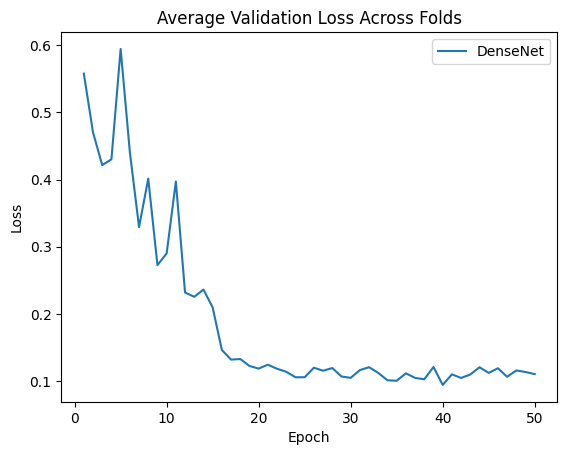

In [36]:
import torch
import numpy as np
from sklearn.model_selection import KFold
import time
start_time = time.time() 
from sklearn.metrics import mean_squared_error

densenet_best_val_loss = float('inf') #mod
densenet_best_model = None #mod

batch_size = 5
k = 5  # 折叠数
num_epochs = 50

kfold = KFold(n_splits=k, shuffle=True)

# 初始化一个数组来保存每个折叠的验证损失
densenet_val_losses_list = [] #mod

# 通过循环，每个折叠都创建一个新的模型并进行训练
for fold, (train_indices, val_indices) in enumerate(kfold.split(combined_dataset)):
    print(f"Fold {fold+1}/{k}")
    print("-" * 10)
     
    # 根据索引创建训练集和验证集的子集
    train_subset = torch.utils.data.Subset(combined_dataset, train_indices)
    val_subset = torch.utils.data.Subset(combined_dataset, val_indices)

    # 创建训练集和验证集的数据加载器
    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    
    # 載入預訓練模型
    # get list of models
    model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)
    model = model.to(device)
    
    # 将模型的最后一层替换为适合你的任务的新的全连接层
    num_classes = 1  # 因為使用 BCEWithLogitsLoss，只需一個輸出節點
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    
    # 定义损失函数
    criterion = nn.BCEWithLogitsLoss()
    
    # 定义优化器
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)
    
    # 设置学习率调度器（可选）
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1) 

    # 初始化训练和验证损失列表
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        # 訓練階段
        model.train()
        train_loss = 0.0
        train_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = (labels.unsqueeze(1)).to(device) 
            model = model.to(device)
            optimizer.zero_grad()

            # 前向傳播
            outputs = model(inputs)
            
            #用來算ACC
            pred = torch.sigmoid(outputs).round().long()
            
            loss = criterion(outputs, labels.float())
            # 反向傳播和參數更新
            loss.backward()
            optimizer.step()
        
        
            train_loss += loss.item() * inputs.size(0)
            train_corrects += torch.sum(torch.eq(pred, labels))

            
        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_corrects / len(train_loader.dataset)

        print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")
        train_losses.append(train_loss)

        # 驗證階段
        model.eval()
        val_loss = 0.0
        val_corrects = 0
    
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = (labels.unsqueeze(1)).to(device) 
                
                # 前向傳播
                outputs = model(inputs)
                
                #用來算ACC
                pred = torch.sigmoid(outputs).round().long()
                
                loss = criterion(outputs, labels.float())

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(torch.eq(pred, labels))

        val_loss = val_loss / len(test_loader.dataset)
        val_acc = val_corrects / len(test_loader.dataset)

        print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
        val_losses.append(val_loss)

        # 學習率調度器更新
        scheduler.step()
    
    if val_loss < densenet_best_val_loss:
        densenet_best_val_loss = val_loss #mod
        Fold = fold+1
        densenet_best_model = model.state_dict() #mod
    
    # 繪製每个 epoch 的训练和验证损失折线图
    #plt.plot(range(1, epoch + 2), train_losses, label=f'Fold {fold+1} Training Loss')
    #plt.plot(range(1, epoch + 2), val_losses, label=f'Fold {fold+1} Validation Loss')
    #plt.xlabel('Epoch')
    #plt.ylabel('Loss')
    #plt.title('Training and Validation Loss')
    #plt.legend()
    #plt.show()
        
    # 将每个折叠的验证损失列表保存到总列表中
    densenet_val_losses_list.append(val_losses) #mod

# 记录结束时间
end_time = time.time()
# 计算时间差
execution_time = end_time - start_time
# 输出执行时间
print(f"Execution time: {execution_time} seconds")
print(f"Fold {Fold} is the best")

# 将验证损失列表转换为numpy数组
val_losses_array = np.array(densenet_val_losses_list) #mod

# 计算所有折叠的验证损失平均值
densenet_mean_val_losses = np.mean(val_losses_array, axis=0) #mod

# 绘制每个折叠的验证损失平均折线图
plt.plot(range(1, num_epochs + 1), densenet_mean_val_losses, label='DenseNet') #mod
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Validation Loss Across Folds')
plt.legend()
plt.show()

In [37]:
# 現在你的模型已經準備好進行預測了
# 如果是進行預測，你可以將你的輸入資料（例如：val_loader）餵入模型
# 然後獲得模型的預測結果（例如：y_pred）和真實標籤（例如：y_true）：
y_true = []
y_pred = []

with torch.no_grad():
    model.eval()
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 前向傳播
        outputs = model(inputs)
        preds = torch.sigmoid(outputs).round().long()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# 計算混淆矩陣
confusion_mat = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(confusion_mat)

# 生成分類報告
report = classification_report(y_true, y_pred)

print("Classification Report:")
print(report)

Confusion Matrix:
[[136   7]
 [  3  97]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       143
           1       0.93      0.97      0.95       100

    accuracy                           0.96       243
   macro avg       0.96      0.96      0.96       243
weighted avg       0.96      0.96      0.96       243



# VGG16

Fold 1/5
----------


C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50
----------
Train Loss: 0.7056 Acc: 0.5544
Val Loss: 0.6882 Acc: 0.5492
Epoch 2/50
----------
Train Loss: 0.6768 Acc: 0.5739
Val Loss: 0.6573 Acc: 0.5861
Epoch 3/50
----------
Train Loss: 0.6507 Acc: 0.6099
Val Loss: 0.6074 Acc: 0.6680
Epoch 4/50
----------
Train Loss: 0.6398 Acc: 0.6150
Val Loss: 0.6676 Acc: 0.6516
Epoch 5/50
----------
Train Loss: 0.6027 Acc: 0.6550
Val Loss: 0.5379 Acc: 0.7459
Epoch 6/50
----------
Train Loss: 0.5888 Acc: 0.6817
Val Loss: 0.5714 Acc: 0.7418
Epoch 7/50
----------
Train Loss: 0.5213 Acc: 0.7331
Val Loss: 0.6711 Acc: 0.6025
Epoch 8/50
----------
Train Loss: 0.4567 Acc: 0.7782
Val Loss: 0.4216 Acc: 0.8033
Epoch 9/50
----------
Train Loss: 0.4585 Acc: 0.7731
Val Loss: 0.4901 Acc: 0.7705
Epoch 10/50
----------
Train Loss: 0.4537 Acc: 0.7803
Val Loss: 0.4395 Acc: 0.7910
Epoch 11/50
----------
Train Loss: 0.3607 Acc: 0.8368
Val Loss: 0.4180 Acc: 0.7951
Epoch 12/50
----------
Train Loss: 0.3399 Acc: 0.8409
Val Loss: 0.4004 Acc: 0.7910
Epoch 13/50
-

Train Loss: 0.0201 Acc: 0.9969
Val Loss: 0.1885 Acc: 0.9426
Fold 3/5
----------
Epoch 1/50
----------
Train Loss: 0.6770 Acc: 0.6016
Val Loss: 0.6749 Acc: 0.5205
Epoch 2/50
----------
Train Loss: 0.6517 Acc: 0.6150
Val Loss: 0.6201 Acc: 0.6762
Epoch 3/50
----------
Train Loss: 0.6053 Acc: 0.6602
Val Loss: 0.6861 Acc: 0.5164
Epoch 4/50
----------
Train Loss: 0.6165 Acc: 0.6602
Val Loss: 0.5913 Acc: 0.7131
Epoch 5/50
----------
Train Loss: 0.5733 Acc: 0.6930
Val Loss: 0.5555 Acc: 0.7336
Epoch 6/50
----------
Train Loss: 0.4823 Acc: 0.7669
Val Loss: 0.4860 Acc: 0.7746
Epoch 7/50
----------
Train Loss: 0.4763 Acc: 0.7793
Val Loss: 0.4549 Acc: 0.7869
Epoch 8/50
----------
Train Loss: 0.4061 Acc: 0.8142
Val Loss: 0.6019 Acc: 0.7213
Epoch 9/50
----------
Train Loss: 0.3879 Acc: 0.8224
Val Loss: 0.4477 Acc: 0.7951
Epoch 10/50
----------
Train Loss: 0.3784 Acc: 0.8306
Val Loss: 0.3648 Acc: 0.8279
Epoch 11/50
----------
Train Loss: 0.3427 Acc: 0.8388
Val Loss: 0.3316 Acc: 0.8525
Epoch 12/50
----

Train Loss: 0.0185 Acc: 0.9990
Val Loss: 0.2787 Acc: 0.8889
Epoch 50/50
----------
Train Loss: 0.0201 Acc: 0.9938
Val Loss: 0.3139 Acc: 0.8889
Fold 5/5
----------
Epoch 1/50
----------
Train Loss: 0.7110 Acc: 0.5169
Val Loss: 0.6834 Acc: 0.6255
Epoch 2/50
----------
Train Loss: 0.6898 Acc: 0.5538
Val Loss: 0.6460 Acc: 0.6255
Epoch 3/50
----------
Train Loss: 0.6581 Acc: 0.6133
Val Loss: 0.5862 Acc: 0.7366
Epoch 4/50
----------
Train Loss: 0.6235 Acc: 0.6646
Val Loss: 0.6151 Acc: 0.6584
Epoch 5/50
----------
Train Loss: 0.5884 Acc: 0.6913
Val Loss: 0.4731 Acc: 0.7654
Epoch 6/50
----------
Train Loss: 0.5517 Acc: 0.7200
Val Loss: 0.5096 Acc: 0.7531
Epoch 7/50
----------
Train Loss: 0.5262 Acc: 0.7508
Val Loss: 0.4749 Acc: 0.7613
Epoch 8/50
----------
Train Loss: 0.4653 Acc: 0.7805
Val Loss: 0.4151 Acc: 0.8230
Epoch 9/50
----------
Train Loss: 0.4437 Acc: 0.7856
Val Loss: 0.3741 Acc: 0.8107
Epoch 10/50
----------
Train Loss: 0.6094 Acc: 0.6144
Val Loss: 0.6219 Acc: 0.6502
Epoch 11/50
----

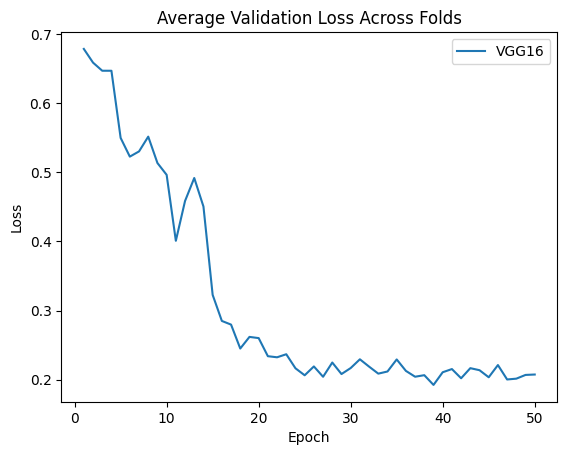

In [43]:
import torch
import numpy as np
from sklearn.model_selection import KFold
import time
start_time = time.time() 
from sklearn.metrics import mean_squared_error

vgg16_best_val_loss = float('inf') #mod
vgg16_best_model = None #mod

batch_size = 5
k = 5  # 折叠数
num_epochs = 50

kfold = KFold(n_splits=k, shuffle=True)

# 初始化一个数组来保存每个折叠的验证损失
vgg16_val_losses_list = [] #mod

# 通过循环，每个折叠都创建一个新的模型并进行训练
for fold, (train_indices, val_indices) in enumerate(kfold.split(combined_dataset)):
    print(f"Fold {fold+1}/{k}")
    print("-" * 10)
     
    # 根据索引创建训练集和验证集的子集
    train_subset = torch.utils.data.Subset(combined_dataset, train_indices)
    val_subset = torch.utils.data.Subset(combined_dataset, val_indices)

    # 创建训练集和验证集的数据加载器
    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    
    # 載入預訓練模型
    # get list of models
    model = models.vgg16(pretrained=True)
    model = model.to(device)

    num_ftrs = model.classifier[6].in_features
    num_classes = 1  
    model.classifier[6] = nn.Linear(num_ftrs, num_classes)
    
    # 定义损失函数
    criterion = nn.BCEWithLogitsLoss()
    
    # 定义优化器
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)
    
    # 设置学习率调度器（可选）
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1) 

    # 初始化训练和验证损失列表
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        # 訓練階段
        model.train()
        train_loss = 0.0
        train_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = (labels.unsqueeze(1)).to(device) 
            model = model.to(device)
            optimizer.zero_grad()

            # 前向傳播
            outputs = model(inputs)
            
            #用來算ACC
            pred = torch.sigmoid(outputs).round().long()
            
            loss = criterion(outputs, labels.float())
            # 反向傳播和參數更新
            loss.backward()
            optimizer.step()
        
        
            train_loss += loss.item() * inputs.size(0)
            train_corrects += torch.sum(torch.eq(pred, labels))

            
        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_corrects / len(train_loader.dataset)

        print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")
        train_losses.append(train_loss)

        # 驗證階段
        model.eval()
        val_loss = 0.0
        val_corrects = 0
    
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = (labels.unsqueeze(1)).to(device) 
                
                # 前向傳播
                outputs = model(inputs)
                
                #用來算ACC
                pred = torch.sigmoid(outputs).round().long()
                
                loss = criterion(outputs, labels.float())

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(torch.eq(pred, labels))

        val_loss = val_loss / len(test_loader.dataset)
        val_acc = val_corrects / len(test_loader.dataset)

        print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
        val_losses.append(val_loss)

        # 學習率調度器更新
        scheduler.step()
    
    if val_loss < vgg16_best_val_loss:
        vgg16_best_val_loss = val_loss #mod
        Fold = fold+1
        vgg16_best_model = model.state_dict() #mod
    
    # 繪製每个 epoch 的训练和验证损失折线图
    #plt.plot(range(1, epoch + 2), train_losses, label=f'Fold {fold+1} Training Loss')
    #plt.plot(range(1, epoch + 2), val_losses, label=f'Fold {fold+1} Validation Loss')
    #plt.xlabel('Epoch')
    #plt.ylabel('Loss')
    #plt.title('Training and Validation Loss')
    #plt.legend()
    #plt.show()
        
    # 将每个折叠的验证损失列表保存到总列表中
    vgg16_val_losses_list.append(val_losses) #mod

# 记录结束时间
end_time = time.time()
# 计算时间差
execution_time = end_time - start_time
# 输出执行时间
print(f"Execution time: {execution_time} seconds")
print(f"Fold {Fold} is the best")

# 将验证损失列表转换为numpy数组
val_losses_array = np.array(vgg16_val_losses_list) #mod

# 计算所有折叠的验证损失平均值
vgg16_mean_val_losses = np.mean(val_losses_array, axis=0) #mod

# 绘制每个折叠的验证损失平均折线图
plt.plot(range(1, num_epochs + 1), vgg16_mean_val_losses, label='VGG16') #mod
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Validation Loss Across Folds')
plt.legend()
plt.show()

In [44]:
# 現在你的模型已經準備好進行預測了
# 如果是進行預測，你可以將你的輸入資料（例如：val_loader）餵入模型
# 然後獲得模型的預測結果（例如：y_pred）和真實標籤（例如：y_true）：
y_true = []
y_pred = []

with torch.no_grad():
    model.eval()
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 前向傳播
        outputs = model(inputs)
        preds = torch.sigmoid(outputs).round().long()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# 計算混淆矩陣
confusion_mat = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(confusion_mat)

# 生成分類報告
report = classification_report(y_true, y_pred)

print("Classification Report:")
print(report)

Confusion Matrix:
[[144   8]
 [  9  82]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       152
           1       0.91      0.90      0.91        91

    accuracy                           0.93       243
   macro avg       0.93      0.92      0.93       243
weighted avg       0.93      0.93      0.93       243



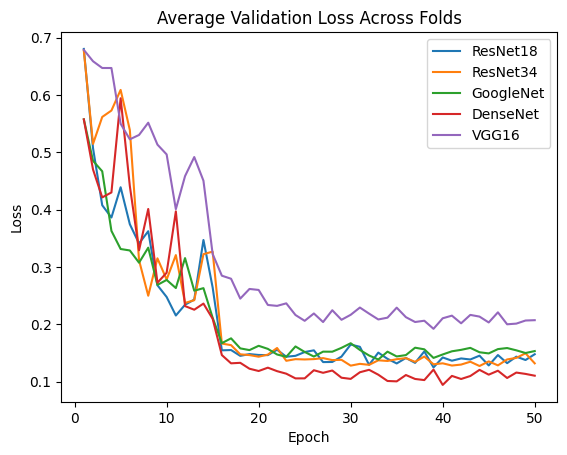

In [45]:
# 绘制每个折叠的验证损失平均折线图
plt.plot(range(1, num_epochs + 1), r18_mean_val_losses, label='ResNet18')
plt.plot(range(1, num_epochs + 1), r34_mean_val_losses, label='ResNet34')
plt.plot(range(1, num_epochs + 1), googlenet_mean_val_losses, label='GoogleNet')
plt.plot(range(1, num_epochs + 1), densenet_mean_val_losses, label='DenseNet')
plt.plot(range(1, num_epochs + 1), vgg16_mean_val_losses, label='VGG16')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Validation Loss Across Folds')
plt.legend()
plt.show()


In [39]:
# 定义保存路径
save_path = "1023_googlenet.pth"
# 保存模型参数
torch.save(googlenet_best_model, save_path)

print("Model parameters saved successfully.")

Model parameters saved successfully.


In [40]:
# 定义保存路径
save_path = "1023_densenet121.pth"
# 保存模型参数
torch.save(densenet_best_model, save_path)

print("Model parameters saved successfully.")

Model parameters saved successfully.


In [46]:
# 定义保存路径
save_path = "1023_vgg16.pth"
# 保存模型参数
torch.save(vgg16_best_model, save_path)

print("Model parameters saved successfully.")

Model parameters saved successfully.


In [41]:
# 定义保存路径
save_path = "1023_ResNet34.pth"
# 保存模型参数
torch.save(R34_best_model, save_path)

print("Model parameters saved successfully.")

Model parameters saved successfully.


In [42]:
# 定义保存路径
save_path = "1023_ResNet18.pth"
# 保存模型参数
torch.save(R18_best_model, save_path)
print("Model parameters saved successfully.")

Model parameters saved successfully.
